## 1. Requirements

In [ ]:
#!pip install torch==1.12.0+cu113 torchvision==0.13.0+cu113 torchaudio==0.12.0 -f https://download.pytorch.org/whl/torch_stable.html

In [1]:
import numpy as np
import json

import torchattacks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchsummary
from torchvision.utils import save_image
import PIL
from datetime import datetime

from PIL import Image,ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os

In [2]:
torch.__version__

'1.11.0+cu113'

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [4]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

## 3. Prepare Data

In [5]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./model/mnist_class_PGD.json"))
print(len(class_idx))
idx2label = [class_idx[str(i)] for i in range(len(class_idx))]
print(idx2label)

10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
transform = transforms.Compose([
    #transforms.Resize((581, 581)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Grayscale(num_output_channels=1),
])

In [7]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [8]:
normal_data = image_folder_custom_label(root = './Dataset/Corrupted', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [9]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


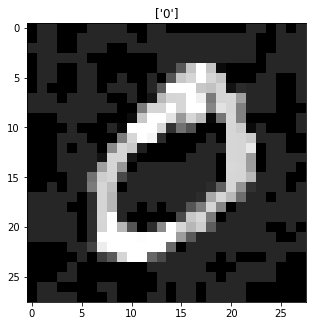

torch.Size([1, 1, 28, 28])


In [10]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()
print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])
print(images.shape)

In [11]:
model = torch.load('./model/MNIST.pth')# Loading the Trained on the MNIST Dataset
model.eval()
print(model)#Printing the Model Architecture
if torch.cuda.is_available():
    model.cuda()
#torchsummary.summary(model,(3,512,512))

GraphModule(
  (initializers): Module()
  (Reshape_0): OnnxReshape()
  (Conv_0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (Relu_0): ReLU()
  (Pad_0): OnnxPadDynamic()
  (MaxPool_0): MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=[0, 0], dilation=1, ceil_mode=False)
  (Conv_1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Conv_2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (Relu_1): ReLU()
  (Conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_2): ReLU()
  (Conv_4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Add_0): OnnxBinaryMathOperation()
  (Relu_3): ReLU()
  (Conv_5): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (Relu_4): ReLU()
  (Conv_6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_5): ReLU()
  (Conv_7): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (Add_1): OnnxBinaryMathOperation()
  (Relu_6): ReLU()
  (Conv_8): Conv2d(256, 64, kernel_size=(1, 

## 5. Rectificaion

$$x^{t+1} = \Pi_{x+S}(x^t-\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations

In [12]:
def pgd_rect(model, images, labels, eps=0.4, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images - alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

In [13]:
# print("Rectified Image & Predicted Label")

model.eval()

correct = 0
total = 0

allFiles, _ = map(list, zip(*normal_loader.dataset.samples))

for i, (images, labels) in enumerate(normal_loader):
    
    images = pgd_rect(model, images, labels)
    labels = labels.to(device)
    outputs = model(images)
    
    #print(i)
    for j in range(images.size()[0]):
        
        path_size = len(allFiles[ i ])
        im_name = ''
        for k in range(path_size, 1, -1):
            if(allFiles[i][k-1] != '/'):
                im_name = im_name + allFiles[i][k-1]
            else:
                break
        im_name = list(im_name)
        im_name.reverse()
        im_name = ''.join(im_name)
        
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()

#    save_image(images, './Dataset/Rectified/'+ im_name )
#     print(im_name)
#     print('number %d image has been successfully saved. %s' % (i,datetime.now().time()))
    i = i+1
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

Attack Image & Predicted Label
Accuracy of test text: 100.000000 %
